#**Keras-Unet_cell_segmentation_scaleup.ipynb**
Train the UNet model with a larger dataset (540 images) and test the trained model with a test dataset (68 images).

# Configure Python environment

## load required modules

In [1]:
import os
import re
import sys
import numpy as np
import pandas as pd
import cv2
import json
import random
import skimage
from glob import glob
from PIL import Image
from PIL.ExifTags import TAGS
from pathlib import Path
from tqdm import tqdm
from google.colab import drive
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.layers import concatenate

import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import Callback, ModelCheckpoint
from keras.models import load_model

from sklearn.model_selection import train_test_split

## mount google drive

In [2]:
GD_PATH = '/content/drive'

if os.path.exists(GD_PATH) :
    print ('Google drive has mounted.')
else :
    drive.mount(GD_PATH)
# Path to train and test dataset
TRAIN_PATH = os.path.join(GD_PATH, 'My Drive', 'cellimages', 'cell_images', 'train')
TEST_PATH = os.path.join(GD_PATH, 'My Drive', 'cellimages', 'cell_images', 'test')

Mounted at /content/drive


## General variables

In [3]:
N_CHANNEL = 3
BATCH_SIZE = 32
HEIGHT = 256
WIDTH = 256
N_CLASSES = 3
RANDOM_STATE = 2023

# Some functions

In [4]:
def image_loader(path, suffix) :
    ''' image_loader find the files of the given suffix under the given path, output a list containing the whole path for each file.'''
    import os

    fn_list = []
    for path, _, names in os.walk(path) :
        for fn in names :
            if fn.endswith(suffix) :
                fn_list.append(os.path.join(path, fn))

    return fn_list

def get_imageEXIF(fn) :
    '''get_imageEXIF retrieve the image metadata'''
    from PIL import Image
    from PIL.ExifTags import TAGS

    meta_data = {}
    image = Image.open(fn)
    for key, value in image.getexif().items() :
        if key in TAGS :
            meta_data[TAGS[key]] = value

    return meta_data

def image_plot_1by2(image, label) :
    '''image_plot_1by2 generates original image and its label from their numpy array in 1X2.'''
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.set_title('Image')
    ax2.set_title('Label')
    ax1.imshow(image)
    ax2.imshow(label)

def image_label_display(fn1, fn2) :
    '''image_label_display shows the image and its labels side-by-side.
    Param
        fn1: the path to the image file;
        fn2: the path to the label files.
    Returns
        None. But show the images.'''

    import cv2
    import matplotlib.pyplot as plt
    from glob import glob

    image = cv2.imread(fn1, cv2.IMREAD_COLOR)
    label = np.zeros(image.shape)
    for fn in fn2 :
        label_ = cv2.imread(fn, cv2.IMREAD_GRAYSCALE)
        label_ = np.expand_dims(label_, axis=-1)
        label = np.maximum(label, label_)

    # Plot the figures
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.set_title('Image')
    ax2.set_title('Label')
    ax1.imshow(image)
    ax2.imshow(label)

def RLE_encoding(image, binary=True) :
    '''RLE_encoding generates the run length encoding of input binary image.
    Params
        image:
        binary: True in default;

    Returns
        rle: 1-D numpy array of RLE codings'''
    # RLE encoding
    rle = [] # Store RLE coding
    start = 0
    length = 0
    prev = None # Use to check previous pixel
    image = image.flatten() # Flatten the image numpy array

    for indice, pixel in enumerate(image) :

        if prev == None : # The first pixel
            prev = pixel

        if pixel == 0 : # Background
            prev = pixel

            # Record start and length
            if (start > 0) and (start not in rle) :
                rle.extend([start, length])

        if pixel == 1 : # Signal

            if pixel != prev : # Encounter the first signal pixel

                start = indice # Record start indice
                length = 1
                prev = pixel

            else : # The following signal pixel

                length += 1
                prev = pixel

    return np.array(rle)

def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    #starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)

def image_label_gen(df) :
    '''A generator return image and label (ground truth) from a csvfile, which records one label for one image per row.'''

    for name in df['name'].unique() :
        path = df[df.name == name].iloc[0,5]
        width = df[df.name == name].iloc[0,2]
        height = df[df.name == name].iloc[0,3]
        annotations = df[df.name == name].iloc[:,1]
        num_channels = int(df[df.name == name].iloc[0,8])
        bit = re.search(r'\d+', df[df.name == name].iloc[0,6]).group()
        # read image and resize it
        image = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        if len(image.shape) == 2 :
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        image = cv2.resize(image, DIM, interpolation=cv2.INTER_AREA)
        image = image.astype(np.float32)
        if bit == '8' :
          image = image / 255
        elif bit == '16' :
          image = image / (257 * 255)
        # ground truth
        label = np.zeros((height, width), dtype=np.float32)
        for rle in annotations :
            mask = rle_decode(rle[1:-1], (height, width), color=1)
            label = np.maximum(label, mask)
        label = cv2.resize(label, DIM, interpolation=cv2.INTER_AREA)

        yield (image, label)

def image_normalize(src):
    '''Normalize the input numpy array by setting non-zero element to 255.
    Params
    ------
        src: numpy array
    Returns
    -------
        numpy array
    '''
    src_flatten = src.flatten()
    dst = np.array([x if x == 0 else 255 for x in src_flatten]).reshape(src.shape)

    return dst

# Image Preprocessing
The image preprocessing step extracts the following informations out of each image and record them in a pandas dataframe, one label of a image per row.
1. 'image_name': image name (string)
2. 'width': image width (int)
3. 'height': image height (int)
4. 'image_path': the aboslute path to image (string)
5. 'number_of_channel': color space (string)
6. 'bit_depth': image dtype (string)
7. 'masks_path': the aboslute path to the masks image (string)
8. 'masks_channels': color space of the masks image (string)
9. 'masks_bit': masks image dtype (string)

In [ ]:
train_images = image_loader(TRAIN_PATH, 'img.png')
test_images = image_loader(TEST_PATH, 'img.png')

In [ ]:
print (f'The number of images in train dataset: {len(train_images)}')
print (f'The number of images in test dataset: {len(test_images)}')

The number of images in train dataset: 540
The number of images in test dataset: 68


In [ ]:
column_names = ['image_name', 'width', 'height', 'image_path', 'number_of_channel', 'bit_depth', 'masks_path', 'masks_channels', 'masks_bit']

train_list = []

for fn in train_images:
    _dict = dict.fromkeys(column_names, '')
    _dict['image_name'] = os.path.basename(fn)
    _dict['image_path'] = fn

    _image = cv2.imread(fn, cv2.IMREAD_UNCHANGED)
    _dict['width'] = _image.shape[1]
    _dict['height'] = _image.shape[0]
    _dict['bit_depth'] = _image.dtype
    _dict['number_of_channel'] = _image.shape[2] if len(_image.shape) == 3 else 1

    if os.path.exists(fn.replace('img.png', 'masks.png')):
        _dict['masks_path'] = fn.replace('img.png', 'masks.png')
        _masks = cv2.imread(_dict['masks_path'], cv2.IMREAD_UNCHANGED)
        _dict['masks_bit'] = _masks.dtype
        _dict['masks_channels'] = _masks.shape[2] if len(_masks.shape) == 3 else 1
    else:
        continue

    train_list.append(_dict)

test_list = []

for fn in test_images:
    _dict = dict.fromkeys(column_names, '')
    _dict['image_name'] = os.path.basename(fn)
    _dict['image_path'] = fn

    _image = cv2.imread(fn, cv2.IMREAD_UNCHANGED)
    _dict['width'] = _image.shape[1]
    _dict['height'] = _image.shape[0]
    _dict['bit_depth'] = _image.dtype
    _dict['number_of_channel'] = _image.shape[2] if len(_image.shape) == 3 else 1

    if os.path.exists(fn.replace('img.png', 'masks.png')):
        _dict['masks_path'] = fn.replace('img.png', 'masks.png')
        _masks = cv2.imread(_dict['masks_path'], cv2.IMREAD_UNCHANGED)
        _dict['masks_bit'] = _masks.dtype
        _dict['masks_channels'] = _masks.shape[2] if len(_masks.shape) == 3 else 1
    else:
        continue

    test_list.append(_dict)

train_df = pd.DataFrame(train_list, columns=column_names)
test_df = pd.DataFrame(test_list, columns=column_names)

In [ ]:
train_df.to_csv(os.path.join(GD_PATH, 'My Drive', 'cellimages', 'cell_images', 'train_images.csv'))
test_df.to_csv(os.path.join(GD_PATH, 'My Drive', 'cellimages', 'cell_images', 'test_images.csv'))

In [5]:
train_df = pd.read_csv(os.path.join(GD_PATH, 'My Drive', 'cellimages', 'cell_images', 'train_images.csv'), index_col=0)
test_df = pd.read_csv(os.path.join(GD_PATH, 'My Drive', 'cellimages', 'cell_images', 'test_images.csv'), index_col=0)

## Data pipeline

In [6]:
class DataGenerator(tf.keras.utils.Sequence):
    '''Generates data for Keras'''
    def __init__(self, list_IDs, df=train_df, mode='fit', dim=(HEIGHT, WIDTH),
                 batch_size=BATCH_SIZE, n_channels=N_CHANNEL,
                 n_classes=N_CLASSES, random_state=RANDOM_STATE, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state

        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]

        X = self.__generate_X(list_IDs_batch)

        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            return X, y

        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)

    def __generate_X(self, list_IDs_batch):
        '''Retrieve image'''
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        # Get image
        for i, ID in enumerate(list_IDs_batch):
            img = self.__load_rgb(ID)

            X[i,] = img

        return X

    def __generate_y(self, list_IDs_batch):
        '''Restore image label'''
        # Initialization
        y = np.empty((self.batch_size, *self.dim, self.n_channels), dtype=np.float32)
        # Get masks
        for i, ID in enumerate(list_IDs_batch):
            masks_path = self.df[self.df['image_name'] == ID]['masks_path'].values[0]
            masks_bit = self.df[self.df['image_name'] == ID]['masks_bit'].values[0]
            masks = cv2.imread(masks_path, cv2.IMREAD_UNCHANGED)
            # Convert 16-bit to 8-bit
            if masks_bit == 'uint16':
                masks = masks.astype('uint8')
            # Resize
            masks = cv2.resize(masks, self.dim, interpolation=cv2.INTER_AREA)
            # Convert to binary
            normed = np.array([x if x == 0 else 1 for x in masks.flatten()], dtype='uint8').reshape(self.dim)
            normed = np.expand_dims(normed, axis=-1)

            y[i, ] = normed

        return y

    def __load_grayscale(self, ID):

        image_path = self.df[self.df['image_name'] == ID]['image_path'].values[0]
        image_bit = self.df[self.df['image_name'] == ID]['bit_depth'].values[0]
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        # Convert 16-bit to 8-bit
        if image_bit == 'uint16':
            image = (image/255).astype('uint8')
        # Convert to gray
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Resize
        image = cv2.resize(image, self.dim, interpolation=cv2.INTER_AREA)
        # Normalize
        image = image.astype(np.float32) / 255.
        # Expand dimension if image is 2D array
        if len(image.shape) == 2:
            image = np.expand_dims(image, axis=-1)

        return image

    def __load_rgb(self, ID):

        image_path = self.df[self.df['image_name'] == ID]['image_path'].values[0]
        image_bit = self.df[self.df['image_name'] == ID]['bit_depth'].values[0]
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        # Convert 16-bit to 8-bit
        if image_bit == 'uint16':
            image = (image/255).astype('uint8')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Resize
        image = cv2.resize(image, self.dim, interpolation=cv2.INTER_AREA)
        # Normalize
        image = image.astype(np.float32) / 255.

        return image

In [7]:
train_list = list(train_df['image_name'].values)
train_IDs, validation_IDs = train_test_split(train_list, test_size=0.2, random_state=RANDOM_STATE)
test_IDs = list(test_df['image_name'].values)

print ('The number of train image: ', len(train_IDs))
print ('The number of validation image: ', len(validation_IDs))
print ('The number of test image: ', len(test_IDs))

The number of train image:  432
The number of validation image:  108
The number of test image:  68


In [8]:
# Generate the train, validation and test data input pipeline
train_gen = DataGenerator(
    train_IDs,
    df=train_df,
    batch_size=BATCH_SIZE,
    n_classes=N_CLASSES,
)

validation_gen = DataGenerator(
    validation_IDs,
    df=train_df,
    batch_size=BATCH_SIZE,
    n_classes=N_CLASSES,
)

testset_gen = DataGenerator(
    test_IDs,
    df=test_df,
    batch_size=1,
    n_classes=N_CLASSES,
    mode='predict',
)

In [9]:
print (len(train_gen), len(validation_gen), len(testset_gen))

13 3 68


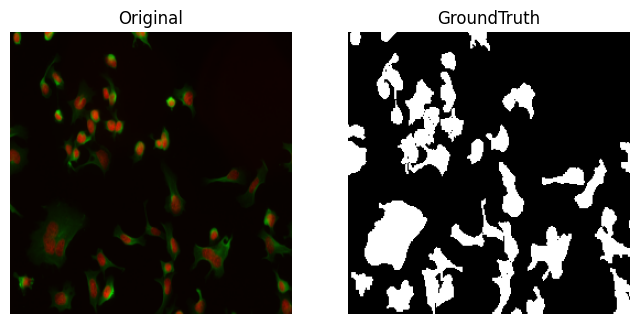

In [10]:
# Visualize some images and their label
i = random.randint(0, len(train_gen))
j = random.randint(0, BATCH_SIZE)

images, labels = train_gen[i]
fig, axs = plt.subplots(1, 2, figsize=(8, 6))
axs[0].imshow(images[j])
axs[0].set_title('Original')
axs[0].axis('off')

axs[1].imshow(labels[j], cmap='gray')
axs[1].set_title('GroundTruth')
axs[1].axis('off')

plt.show()

## U-Net model

### Call for the dependencies for UNet model

In [11]:
!pip install segmentation-models
!pip install git+https://github.com/qubvel/segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 8.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-0e2rqrm8
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models /tmp/pip-req-build-0e2rqrm8
  Resolved https://github.com/qubvel/segmentation_models to commit e951c6747f75fa9e7240816d1c79dd2e66813123
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done


In [12]:
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `tf.keras` framework.


'tf.keras'

### Metrics

In [13]:
# Model metrics
from keras import backend as K
from keras.losses import binary_crossentropy
import tensorflow as tf

class Metrics(object):

    def __init__(self, smooth: int = 1):
        self.smooth = smooth

    def dice_coef(self, y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + self.smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + self.smooth)

    def iou_coef(self, y_true, y_pred):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
        iou = K.mean((intersection + self.smooth) / (union + self.smooth), axis=0)
        return iou

    def dice_loss(self, y_true, y_pred):
        smooth = 1.
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = y_true_f * y_pred_f
        score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
        return 1. - score

    def bce_dice_loss(self, y_true, y_pred):
        return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + 0.5 * self.dice_loss(tf.cast(y_true, tf.float32), y_pred)

In [14]:
# Unet model
class UnetModel:

    def __init__(self, model_path, model_metrics):

        self.model_path = model_path
        self.model_metrics = model_metrics
        self.model = None

        self.load()

    def load(self):
        if self.model == None:

            try:
                self.model = tf.keras.models.load_model(
                    self.model_path,
                    custom_objects=None,
                    compile=False,
                    options=None
                    )

                self.model.compile(
                    optimizer='adam',
                    loss=self.model_metrics.bce_dice_loss,
                    metrics=[self.model_metrics.dice_coef, self.model_metrics.iou_coef, 'accuracy']
                )

            except:

                self.model = None

        else:

            pass

        return self

In [15]:
# Call for the saved UNet model
MODEL_PATH = os.path.join(GD_PATH, 'My Drive', 'cellimages', 'unet_model_8.h5')

def get_model():
    metrics = Metrics()
    model = UnetModel(model_path=MODEL_PATH, model_metrics=metrics).model
    return model

predictor = get_model()
predictor.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 128, 128, 32  128         ['stem_conv[0][0]']              
                                )                                                             

## Train the model

In [16]:
from keras.callbacks import Callback, ModelCheckpoint

checkpoint_path = "rgb_2/cp-{epoch:04d}.ckpt"
checkpoint_path = os.path.join(GD_PATH, 'My Drive', 'cellimages', checkpoint_path)

EPOCHS = 100
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='auto'
)

history = predictor.fit(
    train_gen,
    validation_data=validation_gen,
    callbacks=[checkpoint],
    use_multiprocessing=False,
    workers=4,
    epochs=EPOCHS
)

Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 1.0764 - dice_coef: 0.7179 - iou_coef: 0.5352 - accuracy: 0.3834
Epoch 1: val_loss improved from inf to 2.24135, saving model to /content/drive/My Drive/cellimages/rgb_2/cp-0001.ckpt
13/13 [==============================] - 268s 12s/step - loss: 1.0764 - dice_coef: 0.7179 - iou_coef: 0.5352 - accuracy: 0.3834 - val_loss: 2.2413 - val_dice_coef: 0.3490 - val_iou_coef: 0.1992 - val_accuracy: 0.1157
Epoch 2/100
13/13 [==============================] - ETA: 0s - loss: 0.4874 - dice_coef: 0.8072 - iou_coef: 0.6583 - accuracy: 0.4101
Epoch 2: val_loss did not improve from 2.24135
13/13 [==============================] - 93s 7s/step - loss: 0.4874 - dice_coef: 0.8072 - iou_coef: 0.6583 - accuracy: 0.4101 - val_loss: 3.1544 - val_dice_coef: 0.1980 - val_iou_coef: 0.1144 - val_accuracy: 0.1104
Epoch 3/100
13/13 [==============================] - ETA: 0s - loss: 0.4299 - dice_coef: 0.8316 - iou_coef: 0.6847 - accuracy: 0.3521
E

In [17]:
hist_df = pd.DataFrame(history.history)
hist_df.to_csv(os.path.join(GD_PATH, 'My Drive', 'cellimages', 'history_rgb.csv'))

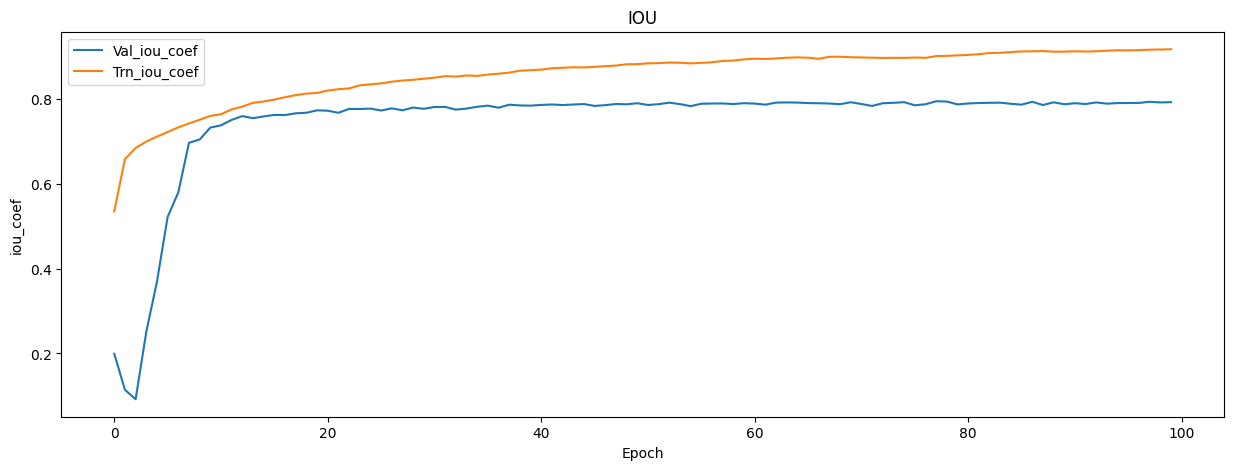

In [18]:
# PLOT TRAINING
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_iou_coef'],label='Val_iou_coef')
plt.plot(range(history.epoch[-1]+1),history.history['iou_coef'],label='Trn_iou_coef')
plt.title('IOU'); plt.xlabel('Epoch'); plt.ylabel('iou_coef');plt.legend();
plt.show()

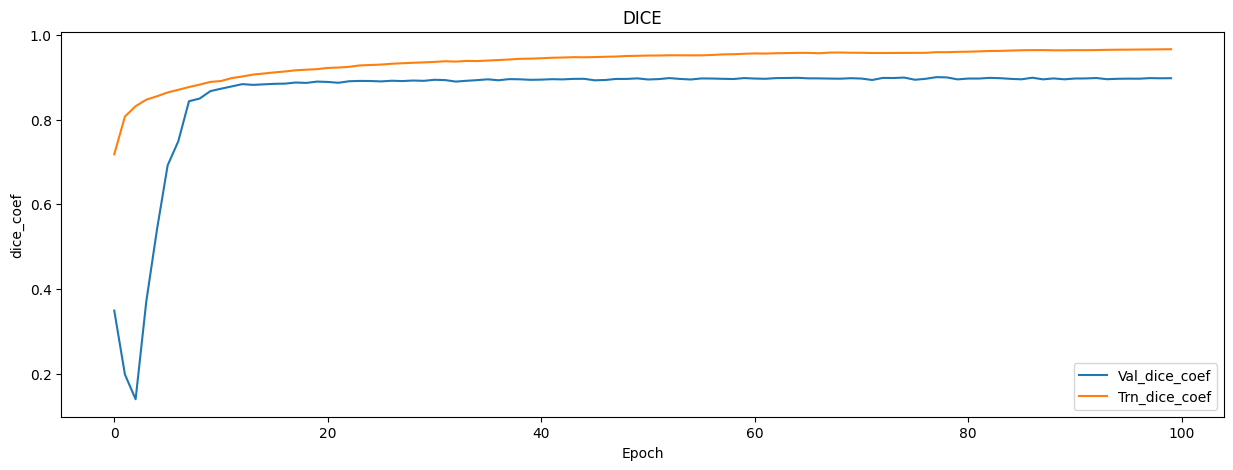

In [19]:
# PLOT TRAINING
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_dice_coef'],label='Val_dice_coef')
plt.plot(range(history.epoch[-1]+1),history.history['dice_coef'],label='Trn_dice_coef')
plt.title('DICE'); plt.xlabel('Epoch'); plt.ylabel('dice_coef');plt.legend();
plt.show()

In [20]:
# Save the model
predictor.save(os.path.join(GD_PATH, 'My Drive', 'cellimages', 'unet_rgb_1.h5'))

## Test the model

In [21]:
predictions = predictor.predict(testset_gen)

68/68 [==============================] - 82s 1s/step


1/1 [==============================] - 0s 55ms/step


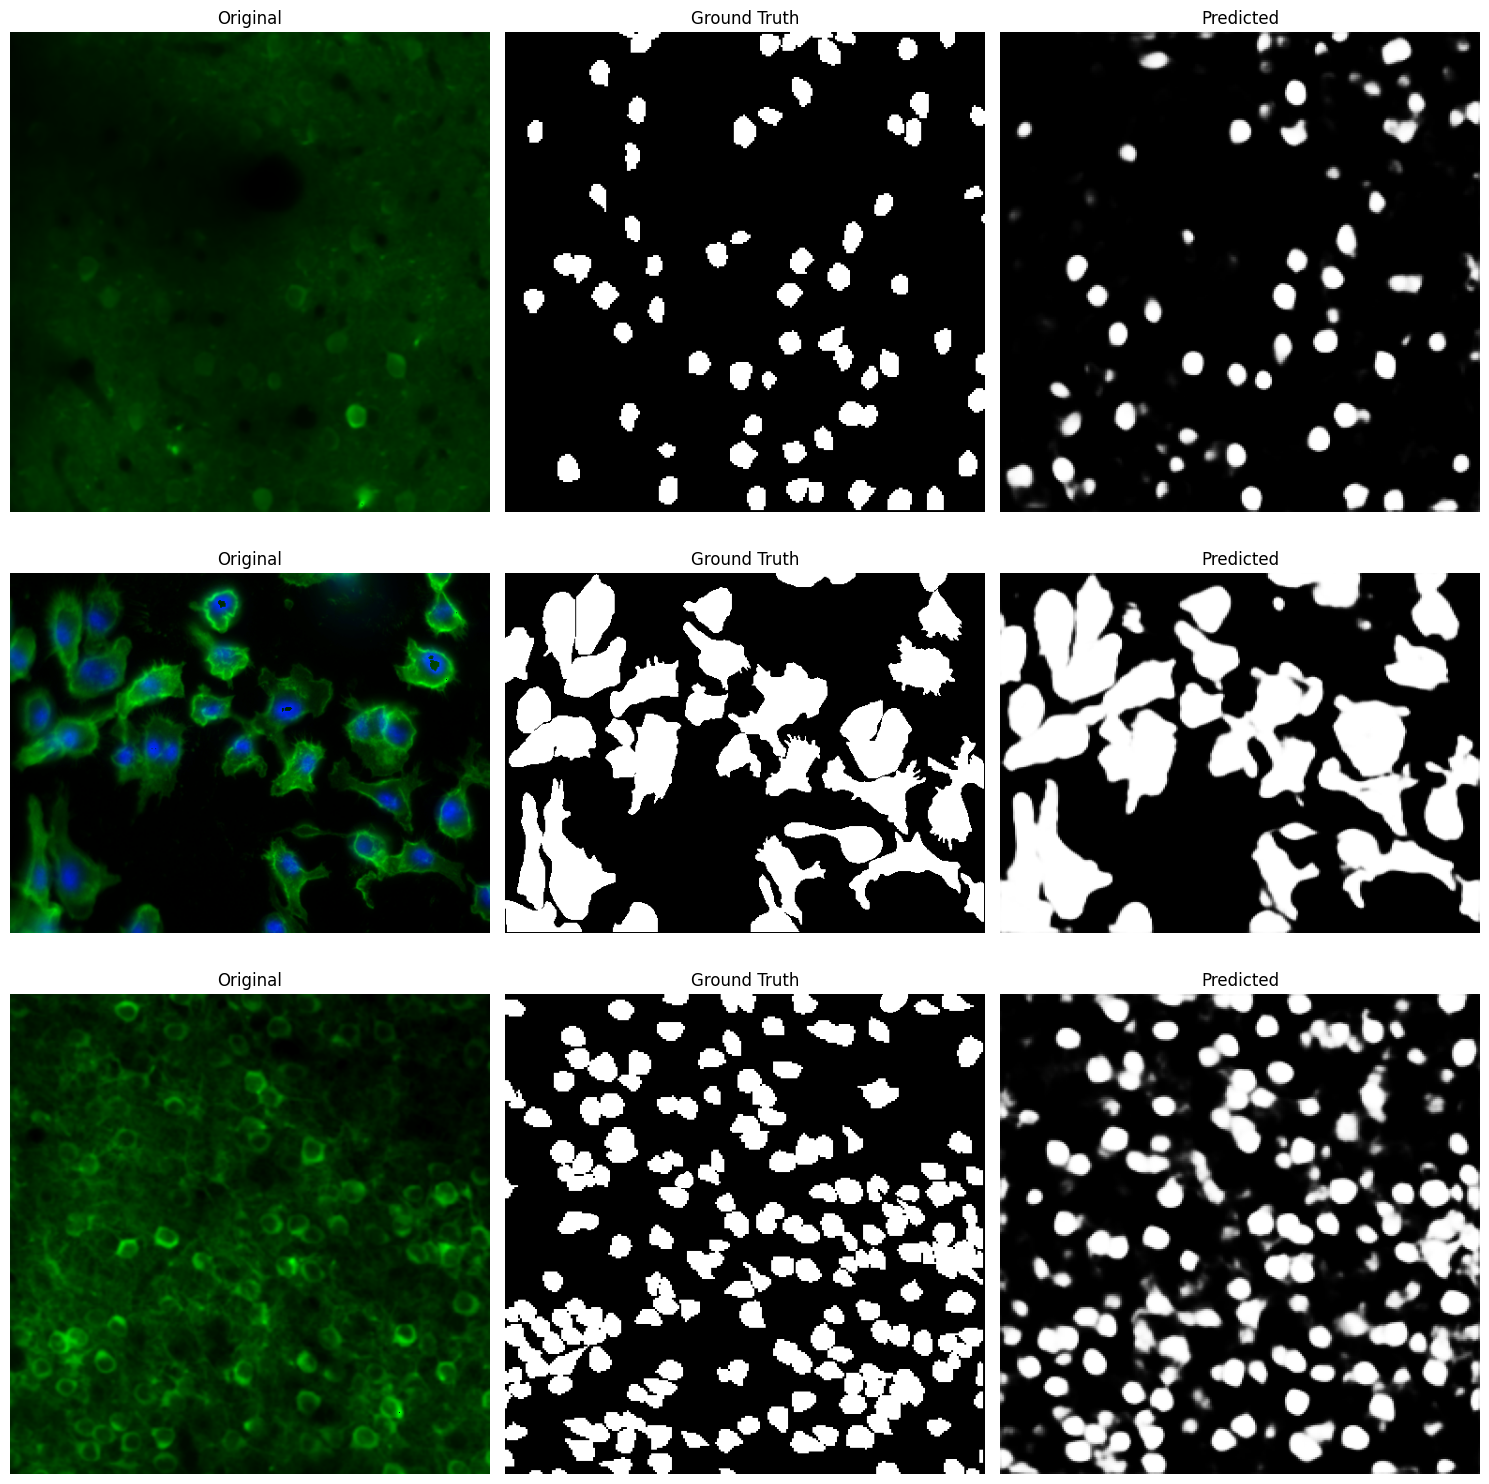

In [37]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i, name in enumerate(random.sample(test_IDs, 3)):

    # Retrieve the original image
    original = cv2.imread(test_df[test_df['image_name'] == name]['image_path'].values[0], cv2.IMREAD_UNCHANGED)
    original = (original/255).astype('uint8')

    # Retrieve the ground truth
    ground_truth = cv2.imread(test_df[test_df['image_name'] == name]['masks_path'].values[0], cv2.IMREAD_UNCHANGED)
    ground_truth = np.array([x if x == 0 else 255 for x in ground_truth.flatten()], dtype='uint8').reshape(original.shape[:2])
    ground_truth = np.expand_dims(ground_truth, axis=-1)

    # Model prediction
    predicted = predictor.predict(
        DataGenerator(
            [name],
            df=test_df,
            batch_size=1,
            n_classes=N_CLASSES,
            mode='predict',
        )
    )

    # Resize the predicted to original size
    predicted = (predicted[0,:,:,:] * 255).astype('uint8')
    predicted = cv2.cvtColor(predicted, cv2.COLOR_BGR2GRAY)
    predicted = cv2.resize(predicted, (original.shape[1], original.shape[0]), interpolation=cv2.INTER_AREA)

    axs[i, 0].imshow(original)
    axs[i, 0].set_title('Original')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(ground_truth, cmap='gray')
    axs[i, 1].set_title('Ground Truth')
    axs[i, 1].axis('off')

    axs[i, 2].imshow(predicted, cmap='gray')
    axs[i, 2].set_title('Predicted')
    axs[i, 2].axis('off')

plt.tight_layout()
plt.show()